In [1]:
# pip install wordcloud
# pip install textblob

import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from textblob import TextBlob
from textblob import Word
import warnings
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
data = pd.read_excel('RedditDataSentimental.xlsx')
data.head()

,Sentence,Sentiment,Sentiment Encoding,Suicidal
0,Ask Reddit: I have a massive list of e-mails I...,Negative,2,No
1,Ask Reddit: What's the best piece of trivia th...,Negative,2,No
2,Basketball coach forced to resign because she ...,Positive,1,No
3,Is this the most optimal way to draw the First...,Netural,0,No
4,Can we get some sort of directory style organi...,Netural,0,No


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87267 entries, 0 to 87266
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Sentence            87249 non-null  object
 1   Sentiment           87267 non-null  object
 2   Sentiment Encoding  87267 non-null  int64 
 3   Suicidal            87267 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [6]:
data.groupby('Suicidal').size().reset_index(name='counts')

,Suicidal,counts
0,No,80631
1,Yes,6636


<AxesSubplot:xlabel='Suicidal', ylabel='count'>

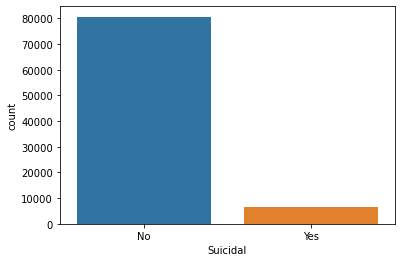

In [7]:
sns.countplot(x=data['Suicidal'])

<AxesSubplot:ylabel='Suicidal'>

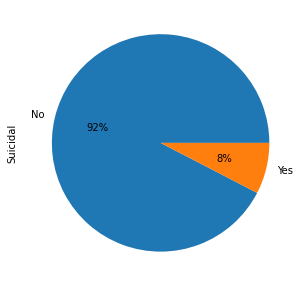

In [8]:
data['Suicidal'].value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(5,5))

In [9]:
data.duplicated().sum()

15

In [10]:
data= data.drop_duplicates()
data = data.dropna(axis = 0)

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def remove_noise(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on text column
data['cleaned']=data['Sentence'].apply(remove_noise)

In [12]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

data['cleaned']=data['cleaned'].apply(clean_text)

In [13]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(remove_special_characters)

In [14]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(simple_stemmer)

In [15]:
#set stopwords to english

nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to C:\Users\Afrime
[nltk_data]     Araf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{"isn't", 'my', 'because', 'wouldn', "hasn't", 'are', 're', "wasn't", 'when', 'own', 'about', 'all', 'her', 'i', "you've", 'until', 'than', "didn't", 'd', 'mustn', 'weren', 'out', 'yours', "you'll", 'ours', 'have', "it's", "don't", 'an', 'their', 'into', 'what', "shouldn't", 'again', "hadn't", 'themselves', 'couldn', 'me', 'before', "you're", 'will', 'down', 'for', "weren't", 'ma', "she's", 'these', 'its', 'other', "wouldn't", 'shan', 'o', 'where', 'at', 'between', 'such', 'were', 'here', 'he', 'whom', 'needn', 'who', 'off', 'hadn', 'ourselves', 'been', 'both', 'the', "mightn't", 'wasn', 'only', 'some', 'does', 'you', "won't", 'once', 'why', 'each', "needn't", 'against', 'most', 'haven', 'nor', 'll', "you'd", 'do', "that'll", 'having', 'while', "haven't", 'hers', 'any', "should've", 'himself', "aren't", 'up', 'very', 'doesn', 'they', 'she', 'myself', 'but', 'is', 'isn', 'yourselves', 'no', 'theirs', 'over', 've', 'we', 'herself', 'was', 'too', 'mightn', 'your', 'his', 'has', 'now', 'in

In [16]:
# Remove the Text with least words
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
dataset = data.loc[data.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Text".format(len(data)-len(dataset)),
      "\nTotal Text:",len(dataset))

After Cleaning: 
Removed 243 Small Text 
Total Text: 87006


In [17]:
data

,Sentence,Sentiment,Sentiment Encoding,Suicidal,cleaned,length
0,Ask Reddit: I have a massive list of e-mails I...,Negative,2,No,ask reddit massiv list email collect gig play ...,18
1,Ask Reddit: What's the best piece of trivia th...,Negative,2,No,ask reddit best piec trivia know true,7
2,Basketball coach forced to resign because she ...,Positive,1,No,basketbal coach forc resign becaus show team m...,10
3,Is this the most optimal way to draw the First...,Netural,0,No,thi optim way draw firstdown line tv turn infr...,17
4,Can we get some sort of directory style organi...,Netural,0,No,get sort directori style organ categori stuff ...,8
...,...,...,...,...,...,...
87262,I really appreciate the time that someone took...,Negative,2,No,realli appreci time someon took make possibl t...,33
87263,I wanted to share my ayahuasca experience that...,Negative,2,No,want share ayahuasca experi wa 16 year old wa ...,53
87264,https://youtu.be/S1KfuErAcj0,Netural,0,No,httpsyoutu bes1kfueracj0,2
87265,"You can have fictional people, fictional food,...",Netural,0,No,fiction peopl fiction food fiction creatur ent...,15


In [18]:
dataset.groupby('Suicidal').size().reset_index(name='counts')

,Suicidal,counts
0,No,80405
1,Yes,6601


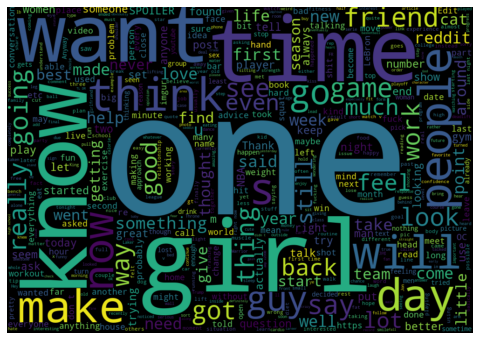

In [19]:
# Plot the positive Word Cloud
pos_df = dataset[dataset['Suicidal'] == 'No']
positive_text = ' '.join([comnt for comnt in pos_df['Sentence']])

WC=WordCloud(width=1000,height=700,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)

fig = plt.figure(1, figsize=(10, 6))
plt.imshow(positive_words, interpolation = "bilinear")
plt.axis('off')
plt.show()

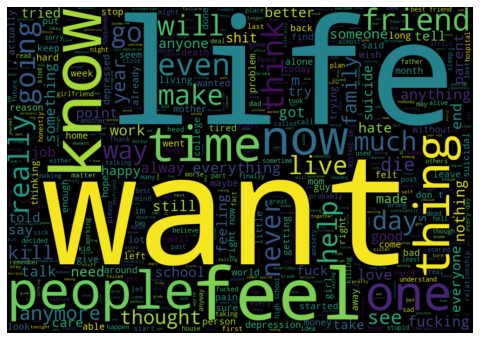

In [20]:
# Plot the negative Word Cloud
neg_df = dataset[dataset['Suicidal'] == 'Yes']
negative_text = ' '.join([comnt for comnt in neg_df['Sentence']])

WC=WordCloud(width=1000,height=700,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)

fig = plt.figure(1, figsize=(10, 6))
plt.imshow(negative_words, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [21]:
#Label Encoding Function
def label_encoding(label,bool):

    le = LabelEncoder()
    le.fit(label)
    encoded_labels = le.transform(label)
    labels = np.array(encoded_labels)
    class_names =le.classes_ 
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(label[i],' ', encoded_labels[i],'\n')

    return labels

In [22]:
#Dataset Splitting Function
def dataset_split(feature_space,label):

    X_train,X_test,y_train,y_test = train_test_split(feature_space,label, test_size = 0.2,random_state =42,stratify=label)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test

In [23]:
#TFIDF to convert text documents to matrix of features
def calc_gram_tfidf(text,gram):

    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(text)
    
    return tfidf,X

#Unigram Tf-idf value calculation
def calc_unigram_tfidf(text):
    tfidf = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(text)
    
    return tfidf,X

#Bi-gram Tf-idf value calculation
def calc_bigram_tfidf(text):
    tfidf = TfidfVectorizer(ngram_range=(1,2),use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(text)
    
    return tfidf,X

#Tri-gram Tf-idf value calculation
def calc_trigram_tfidf(text):
    tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(text)
    
    return tfidf,X

In [24]:
# pip install scikit-surprise

In [25]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score

In [26]:
def model_defination():
    
    rf_model = RandomForestClassifier(criterion ='entropy', random_state = 13)
    
    model_names = ['Random Forest']
    ml_models = [rf_model]
    
    return ml_models,model_names

In [31]:
def model_performace(model,X_train,X_test,y_train,y_test):
    
    my_dict = {}
    model.fit(X_train,y_train)
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100 
    my_dict['Precision'] = round(precision_score(y_test, pred_y,average='micro'),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y,average='micro'),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y,average='micro'),4)*100 
    
    return my_dict  

In [32]:
def performance_table(performance_dict):

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =['RF'])
    performance_df.style.highlight_max(color = 'lightgreen', axis = 0)
    return performance_df

In [33]:
path = "./json/"

In [34]:
## save the performance of the model for each gram feature 
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(1,2),(1,3)]
for i,gram in enumerate(ngrams):
    tfidf,feature = calc_gram_tfidf(dataset['cleaned'],gram)
    labels = label_encoding(dataset['Suicidal'],False)
    X_train,X_test,y_train,y_test = dataset_split(feature,labels) 
    ml_models,model_names = model_defination()
    
    accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}

    with open(path+f'RF_{gram_names[i]}.json', 'w') as f:
          json.dump(accuracy, f)

Feature Size :======> 71519

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 87006 
	Training		 69604 
	Test			 17402
[08:17:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Size :======> 1043664

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 87006 
	Training		 69604 
	Test			 17402
[08:17:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Size :======> 2719448

Dataset Distribution:

	Set Name 		Size

In [35]:
accuracy1 = json.load(open('./json/RF_Unigram.json'))
table1 = performance_table(accuracy1)
table1

,Accuracy,Precision,Recall,F1 Score
RF,96.42,96.42,96.42,96.42


In [36]:
print(f"Highest Accuracy achieved by {table1.Accuracy.idxmax(axis = 0)} at = {max(table1.Accuracy)}")
print(f"Highest F1-Score achieved by {table1['F1 Score'].idxmax(axis = 0)} at = {max(table1['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table1['Precision'].idxmax(axis = 0)} at = {max(table1['Precision'] )}")
print(f"Highest Recall Score achieved by {table1['Recall'].idxmax(axis = 0)} at = {max(table1['Recall'] )}")

Highest Accuracy achieved by RF at = 96.41999999999999
Highest F1-Score achieved by RF at = 96.41999999999999
Highest Precision Score achieved by RF at = 96.41999999999999
Highest Recall Score achieved by RF at = 96.41999999999999


In [37]:
accuracy2 = json.load(open('./json/RF_Bigram.json'))
table2 = performance_table(accuracy2)
table2

,Accuracy,Precision,Recall,F1 Score
RF,96.39,96.39,96.39,96.39


In [38]:
print(f"Highest Accuracy achieved by {table2.Accuracy.idxmax(axis = 0)} at = {max(table2.Accuracy)}")
print(f"Highest F1-Score achieved by {table2['F1 Score'].idxmax(axis = 0)} at = {max(table2['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table2['Precision'].idxmax(axis = 0)} at = {max(table2['Precision'] )}")
print(f"Highest Recall Score achieved by {table2['Recall'].idxmax(axis = 0)} at = {max(table2['Recall'] )}")

Highest Accuracy achieved by RF at = 96.39
Highest F1-Score achieved by RF at = 96.39
Highest Precision Score achieved by RF at = 96.39
Highest Recall Score achieved by RF at = 96.39


In [39]:
accuracy3 = json.load(open('./json/RF_Trigram.json'))
table3 = performance_table(accuracy3)
table3

,Accuracy,Precision,Recall,F1 Score
RF,96.4,96.4,96.4,96.4


In [40]:
print(f"Highest Accuracy achieved by {table3.Accuracy.idxmax(axis = 0)} at = {max(table3.Accuracy)}")
print(f"Highest F1-Score achieved by {table3['F1 Score'].idxmax(axis = 0)} at = {max(table3['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table3['Precision'].idxmax(axis = 0)} at = {max(table3['Precision'] )}")
print(f"Highest Recall Score achieved by {table3['Recall'].idxmax(axis = 0)} at = {max(table3['Recall'] )}")

Highest Accuracy achieved by RF at = 96.39999999999999
Highest F1-Score achieved by RF at = 96.39999999999999
Highest Precision Score achieved by RF at = 96.39999999999999
Highest Recall Score achieved by RF at = 96.39999999999999
